In [1]:
import os
import numpy as np
import pandas as pd
from collections import deque

!pip install music21
!pip install pygame

from music21 import converter, instrument, note, chord, midi, stream, meter

from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
import keras.backend as K
import keras.callbacks
from keras.utils import Sequence
from keras.utils import to_categorical
from keras.preprocessing.sequence import TimeseriesGenerator

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.
Using TensorFlow backend.


In [2]:
directory = "midi/Piano_Beethoven"

In [3]:
instru = instrument.Piano()

In [4]:
notes = [[], []]
durations = [[], []]
hands = (0, 1)

for i, file in enumerate(os.listdir(directory)):
    midi_part = converter.parse(os.path.join(directory, file))
    # Parse the midi file by the notes/chords it contains
    for hand in hands:
        notes_to_parse = midi_part[hand].flat.notesAndRests
        for elem in notes_to_parse:
            if isinstance(elem, note.Note):
                notes[hand].append([str(elem.pitch)])
            elif isinstance(elem, chord.Chord):
                notes[hand].append([str(n.nameWithOctave) for n in elem.pitches])
            elif isinstance(elem, note.Rest):
                notes[hand].append([elem.name])
            durations[hand].append(elem.quarterLength)
        notes[hand].append(["rest"])
        durations[hand].append(1.0)
    print("Song %s Loaded" % file)
print("DONE LOADING SONGS") 

# Get all notes
np_notes = [np.array(notes[hand]) for hand in hands]
np_notes = [np_notes[hand].flatten() for hand in hands]
notes_vocab = [[], []]
for hand in hands:
    for item in np_notes[hand]:
        if len(item) > 1 and item != "rest":
            notes_vocab[hand].append(",".join([note for note in item]))
        else:
            notes_vocab[hand].append(item[0])
    notes_vocab[hand] = sorted(set(notes_vocab[hand]))
# Get all durations
durations_vocab = [[], []]
for hand in hands:
    durations_vocab[hand] = sorted(set(durations[hand]))

for hand in hands:
    print(len(notes_vocab[hand]), len(durations_vocab[hand]), len(notes[hand]))
print(notes_vocab, notes)
print(durations_vocab, durations)

Song be_son1a.mid Loaded
Song be_son1b.mid Loaded
Song be_son1c.mid Loaded
Song be_son1d.mid Loaded
DONE LOADING SONGS
170 31 4991
194 20 5012
[['A2', 'A3', 'A3,A4', 'A3,C4,F4', 'A3,F4', 'A4', 'A4,C#5', 'A4,C5', 'A4,C5,F5', 'A4,D5', 'A4,F5', 'A5', 'A5,F5', 'B-3', 'B-3,B-4', 'B-3,E4', 'B-3,G4', 'B-4', 'B-4,B-5', 'B-4,C#5', 'B-4,C#5,B-5', 'B-4,C#5,F5', 'B-4,D5', 'B-4,E5', 'B-4,E5,G5,B-5', 'B-4,G5', 'B-5', 'B3', 'B3,B4', 'B3,C4', 'B3,D4', 'B3,D4,F4,G#4,B4', 'B4', 'B4,B5', 'B4,D5,F5,G#5,B5', 'B4,D5,G5,B5', 'B5', 'B5,C6', 'C#4', 'C#4,B-4', 'C#4,C#5', 'C#4,E-4,G4', 'C#4,E-4,G4,B-4', 'C#4,E-4,G4,C#5', 'C#5', 'C#5,C#6', 'C#5,E5', 'C#5,F5', 'C#5,G#5,E-6', 'C#6', 'C3,C4', 'C4', 'C4,C5', 'C4,E4', 'C4,E4,G4,C5', 'C4,F4', 'C4,G#4', 'C5', 'C5,B4', 'C5,C6', 'C5,D5', 'C5,E-5', 'C5,E-5,C6', 'C5,E-5,G#5', 'C5,E-5,G5,C6', 'C5,E5', 'C5,F5', 'C5,F5,G#5,C6', 'C5,G#5', 'C5,G5,B-5,C6', 'C6', 'D3', 'D3,F3,G3', 'D3,F3,G3,B3', 'D4', 'D4,C4', 'D4,D5', 'D4,F4,B4', 'D5', 'D5,D6', 'D5,G5', 'D5,G5,B5,D6', 'D6', 'E-3'

In [5]:
# turn notes to integers:
cat_notes = [[], []]
cat_durations = [[], []]
for hand in hands:
    for elem in notes[hand]:
        int_note = notes_vocab[hand].index(",".join(elem))
        cat = np.zeros((len(notes_vocab[hand])))
        cat[int_note] = 1
        cat_notes[hand].append(cat)
    for elem in durations[hand]:
        int_duration = durations_vocab[hand].index(elem)
        cat = np.zeros((len(durations_vocab[hand])))
        cat[int_duration] = 1
        cat_durations[hand].append(cat)
# merge
x = [cat_notes, cat_durations]
x[0][0] = np.array(x[0][0])
x[0][1] = np.array(x[0][1])
x[1][0] = np.array(x[1][0])
x[1][1] = np.array(x[1][1])

In [6]:
seq_len = 32
batch_size = 32
split = int(0.8 * len(x))

class dataGenerator(Sequence):
    def __init__(self, x, batch_size):
        self.batch_size = batch_size
        self.x = x
    def __len__(self):
        return len(self.x[0][0]) // self.batch_size - 1
    def __getitem__(self, idx):
        X_note = [[], []]
        X_duration = [[], []]
        Y_note = [[], []]
        Y_duration = [[], []]
        for hand in hands:
            for i in range(self.batch_size):
                X_note[hand].append(self.x[0][hand][idx+i : idx+i + seq_len])
                X_duration[hand].append(self.x[1][hand][idx+i : idx+i + seq_len])
                Y_note[hand].append(self.x[0][hand][idx+i + seq_len])
                Y_duration[hand].append(self.x[1][hand][idx+i + seq_len])
            X_note[hand] = np.array(X_note[hand])
            X_duration[hand] = np.array(X_duration[hand])
            Y_note[hand] = np.array(Y_note[hand])
            Y_duration[hand] = np.array(Y_duration[hand])
        return [[X_note[0], X_note[1], X_duration[0], X_duration[1]], 
                [Y_note[0], Y_note[1], Y_duration[0], Y_duration[1]]]
data_gen = dataGenerator(x, batch_size)

In [7]:
print(x[0][0].shape, x[0][1].shape, x[1][0].shape, x[1][1].shape)

(4991, 170) (5012, 194) (4991, 31) (5012, 20)


In [9]:
#X
#notes L, R
print(data_gen[0][0][0].shape, data_gen[0][0][1].shape)
#duration L, R
print(data_gen[0][0][2].shape, data_gen[0][0][3].shape)
#Y
#notes L, R
print(data_gen[0][1][0].shape, data_gen[0][1][1].shape)
#durations L, R
print(data_gen[0][1][2].shape, data_gen[0][1][3].shape)

(32, 32, 170) (32, 32, 194)
(32, 32, 31) (32, 32, 20)
(32, 170) (32, 194)
(32, 31) (32, 20)


In [10]:
# Build Model

In [11]:
K.clear_session()

in_note_L = Input(shape=(seq_len, len(notes_vocab[0])))
x1_L = Bidirectional(LSTM(32))(in_note_L)

in_note_R = Input(shape=(seq_len, len(notes_vocab[1])))
x1_R = Bidirectional(LSTM(32))(in_note_R)

in_duration_L = Input(shape=(seq_len, len(durations_vocab[0])))
x2_L = Bidirectional(LSTM(32))(in_duration_L)

in_duration_R = Input(shape=(seq_len, len(durations_vocab[1])))
x2_R = Bidirectional(LSTM(32))(in_duration_R)

concat = Concatenate()([x1_L, x1_R, x2_L, x2_R])
shared = Dense(64, activation='relu')(concat)

out_note_L = Dense(len(notes_vocab[0]), activation='softmax')(shared)
out_note_R = Dense(len(notes_vocab[1]), activation='softmax')(shared)
out_duration_L = Dense(len(durations_vocab[0]), activation='softmax')(shared)
out_duration_R = Dense(len(durations_vocab[1]), activation='softmax')(shared)

model = Model(inputs=[in_note_L, in_note_R, in_duration_L, in_duration_R], 
              outputs=[out_note_L, out_note_R, out_duration_L, out_duration_R])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

W0731 16:15:00.211308  1944 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0731 16:15:00.213033  1944 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0731 16:15:00.235672  1944 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 16:15:00.237253  1944 deprecation_wrapper.py:119] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:51

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 170)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 194)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 32, 31)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 32, 20)       0                                            
__________________________________________________________________________________________________
bidirectio

In [12]:
#save best model if model improved
model_name = "Piano.h5"
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [13]:
h = model.fit_generator(data_gen, epochs = 10, callbacks=[best_checkpoint])

W0731 16:15:08.217750  1944 deprecation.py:323] From c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
154/154 [==============================] - 23s 150ms/step - loss: 9.3098 - dense_2_loss: 3.6132 - dense_3_loss: 3.3548 - dense_4_loss: 1.2970 - dense_5_loss: 1.0448 - dense_2_acc: 0.0984 - dense_3_acc: 0.1784 - dense_4_acc: 0.6737 - dense_5_acc: 0.7265
Epoch 2/10
  1/154 [..............................] - ETA: 10s - loss: 5.8170 - dense_2_loss: 2.8537 - dense_3_loss: 1.8693 - dense_4_loss: 1.0573 - dense_5_loss: 0.0367 - dense_2_acc: 0.1562 - dense_3_acc: 0.4375 - dense_4_acc: 0.5312 - dense_5_acc: 1.0000

c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


154/154 [==============================] - 17s 112ms/step - loss: 5.5594 - dense_2_loss: 2.4691 - dense_3_loss: 2.1013 - dense_4_loss: 0.6079 - dense_5_loss: 0.3811 - dense_2_acc: 0.2315 - dense_3_acc: 0.3082 - dense_4_acc: 0.7772 - dense_5_acc: 0.8610
Epoch 3/10
154/154 [==============================] - 18s 115ms/step - loss: 4.2403 - dense_2_loss: 1.8592 - dense_3_loss: 1.6387 - dense_4_loss: 0.4658 - dense_5_loss: 0.2766 - dense_2_acc: 0.3413 - dense_3_acc: 0.3983 - dense_4_acc: 0.8034 - dense_5_acc: 0.8868
Epoch 4/10
154/154 [==============================] - 18s 119ms/step - loss: 3.4571 - dense_2_loss: 1.4995 - dense_3_loss: 1.3433 - dense_4_loss: 0.3878 - dense_5_loss: 0.2265 - dense_2_acc: 0.4641 - dense_3_acc: 0.4858 - dense_4_acc: 0.8387 - dense_5_acc: 0.9022
Epoch 5/10
154/154 [==============================] - 19s 121ms/step - loss: 2.7777 - dense_2_loss: 1.2224 - dense_3_loss: 1.0629 - dense_4_loss: 0.3122 - dense_5_loss: 0.1801 - dense_2_acc: 0.5974 - dense_3_acc: 0.6441

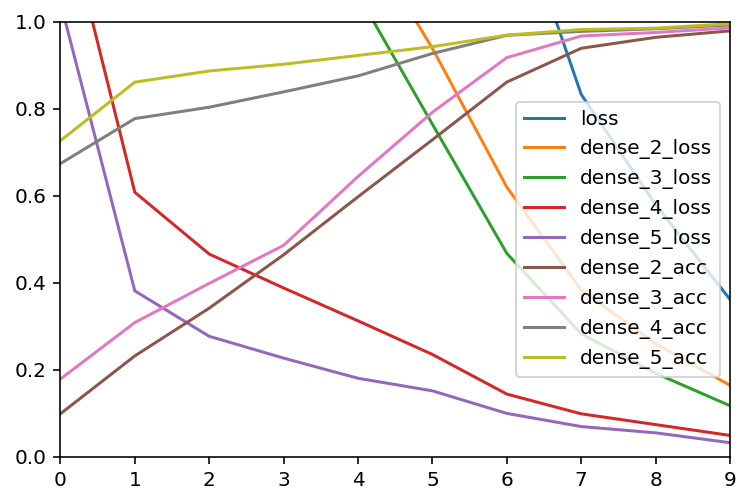

In [16]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [0]:
# Load / save

In [17]:
model.save(model_name)
#model = load_model(os.path.join(base_dir, model_name))

In [119]:
# Build seed
idx = 867
x_test, _ = data_gen[idx]
x_test = [x_test[0][0], x_test[1][0], x_test[2][0], x_test[3][0]]
x_test_stream = [stream.Stream(), stream.Stream()]

for hand in hands:
    for i in range(seq_len):
        str_note = notes_vocab[hand][np.argmax(x_test[0+hand][i])]
        duration = durations_vocab[hand][np.argmax(x_test[2+hand][i])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = duration
            x_test_stream[hand].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = duration
                x_test_stream[hand].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = duration
                x_test_stream[hand].append(_rest)
    x_test_stream[hand].insert(0, instru)
    
print(len(x_test[0]), [(np.argmax(x_test[0][i]), np.argmax(x_test[1][i])) for i, _ in enumerate(x_test[0])])
print(len(x_test[2]), [(np.argmax(x_test[2][i]), np.argmax(x_test[3][i])) for i, _ in enumerate(x_test[2])])

32 [(26, 134), (144, 145), (11, 134), (70, 145), (26, 134), (70, 145), (133, 134), (93, 145), (49, 134), (70, 145), (26, 134), (144, 145), (167, 134), (129, 103), (90, 134), (44, 134), (57, 48), (17, 145), (138, 134), (153, 145), (117, 134), (96, 145), (38, 134), (51, 145), (27, 134), (51, 145), (27, 134), (51, 145), (27, 134), (51, 103), (38, 134), (51, 134)]
32 [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 5), (3, 9), (3, 5), (3, 3), (3, 5), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 5), (3, 9), (3, 5), (3, 3)]


In [120]:
# make seq_len predictions from seed
preds = [[], []]
x = x_test

for i in range(seq_len):
    note_L, note_R, duration_L, duration_R = model.predict([np.array([x[0]]), 
                                                           np.array([x[1]]), 
                                                           np.array([x[2]]), 
                                                           np.array([x[3]])])
    _note = [note_L, note_R]
    _duration = [duration_L, duration_R]
    for hand in hands:
        cat_note = np.zeros((len(notes_vocab[hand])))
        _note[hand] = np.argmax(_note[hand])
        cat_note[_note[hand]] = 1

        cat_duration = np.zeros((len(durations_vocab[hand])))
        _duration[hand] = np.argmax(_duration[hand])
        cat_duration[_duration[hand]] = 1

        x[0+hand] = x[0+hand][1:]
        x[0+hand] = list(x[0+hand]) + [cat_note]
        x[2+hand] = x[2+hand][1:]
        x[2+hand] = list(x[2+hand]) + [cat_duration]
        
        preds[hand].append((cat_note, cat_duration))
print(len(preds[0]), [(np.argmax(pred[0]), np.argmax(pred[1])) for pred in preds[0]])
print(len(preds[1]), [(np.argmax(pred[0]), np.argmax(pred[1])) for pred in preds[1]])

32 [(74, 3), (74, 3), (133, 3), (93, 3), (49, 3), (49, 3), (49, 3), (70, 3), (26, 3), (90, 3), (90, 3), (90, 3), (57, 3), (57, 3), (138, 3), (138, 3), (70, 3), (70, 3), (49, 3), (70, 3), (70, 3), (49, 3), (49, 3), (49, 3), (49, 3), (49, 3), (49, 3), (44, 3), (44, 3), (49, 3), (74, 3), (117, 3)]
32 [(157, 5), (157, 5), (159, 5), (159, 3), (159, 3), (159, 3), (159, 3), (93, 3), (14, 3), (93, 3), (14, 3), (14, 3), (169, 3), (169, 3), (177, 3), (177, 3), (10, 3), (10, 5), (59, 5), (10, 3), (14, 3), (59, 3), (159, 5), (10, 5), (159, 5), (179, 5), (159, 5), (179, 5), (179, 5), (157, 5), (179, 5), (179, 5)]


In [121]:
# Build predicted stream
y_test_stream = [stream.Stream(), stream.Stream()]

for hand in hands:
    for i in range(len(preds[hand])):
        str_note = notes_vocab[hand][np.argmax(preds[hand][i][0])]
        duration = durations_vocab[hand][np.argmax(preds[hand][i][1])]
        if len(str_note.split(",")) > 1:
            _chord = chord.Chord(str_note.split(","))
            _chord.quarterLength = duration
            y_test_stream[hand].append(_chord)
        else:
            if str_note != "rest":
                _note = note.Note(str_note)
                _note.quarterLength = duration
                y_test_stream[hand].append(_note)
            else:
                _rest = note.Rest()
                _rest.quarterLength = duration
                y_test_stream[hand].append(_rest)
    y_test_stream[hand].insert(0, instru)

In [122]:
# play seed
x_full_score = stream.Score()
p1 = stream.Part()
p1.append(x_test_stream[0])
p2 = stream.Part()
p2.append(x_test_stream[1])
x_full_score.insert(0, p1)
x_full_score.insert(0, p2)
x_full_score.chordify()
x_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(x_full_score)
sp.play()

In [123]:
# play generated music
y_full_score = stream.Score()
p1 = stream.Part()
p1.append(y_test_stream[0])
p2 = stream.Part()
p2.append(y_test_stream[1])
y_full_score.insert(0, p1)
y_full_score.insert(0, p2)
y_full_score.chordify()
y_full_score.write("midi", "x_test.mid")
sp = midi.realtime.StreamPlayer(y_full_score)
sp.play()